# Trigger efficiency for Data

##### In this notebook I want to compute the probability for an event with 2 or more lepton jets to contain at least 2 trigger objects from at least one of the following trigger paths:

        - "HLT_DoubleL2Mu23NoVtx_2Cha",
        - "HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched",
        - "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed",
        - "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched",
        - "HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4",
        - "HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4",


##### The computation is divided into 2 parts (the study of Delta R is just a test):
- computing per-object efficiency: probability for a lepton jet (LJ) to contain at least 1 trigger objects (TOs). Using tag and probe method (this part is completed)

- computing per-event efficiency: probability for an event with 2 LJs to contain 2 or more TOs. Using either an anlythical method or a simple montecarlo simulation (this part is NOT completed)

In [2]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
from awkward import JaggedArray
import coffea.processor as processor


import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
#from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import json
datasets_=json.load(open('../Samples/trigger_data_nonempty.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'} ,
    B={'files': datasets_['B'], 'treename': 'ffNtuplizer/ffNtuple'} ,
    C={'files': datasets_['C'], 'treename': 'ffNtuplizer/ffNtuple'} , 
    D={'files': datasets_['D'], 'treename': 'ffNtuplizer/ffNtuple'} ,
)

In [4]:
TriggerList = [ 
        "HLT_DoubleL2Mu23NoVtx_2Cha",
        "HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched",
        "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed",
        "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched",
        "HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4",
        "HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4",
        ]

## Study of Delta R
##### Because I had some problems at the beginning, I made this test for Delta R between TOs and LJs, using only TOHLT_DoubleL2Mu23NoVtx_2Cha.
##### The test consists in studying DeltaR between a fixed TO and the closest LJ or Muon  

In [5]:
class DeltaRProcessor(processor.ProcessorABC):
    def __init__(self):
        
        dataset_axis = hist.Cat('dataset', '')
        multiplicity_axis = hist.Bin("multiplicity", "#muons/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "jet pt [GeV]", 20, 0 , 300)
        deltaR_axis = hist.Bin("deltaR", "$\Delta R$", 30, 0 , 0.5)
        
        self._accumulator = processor.dict_accumulator({
            'deltaR1': hist.Hist("Counts", dataset_axis, deltaR_axis),
            'deltaR2': hist.Hist("Counts", dataset_axis, deltaR_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],      
        )
    
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            muonsPerJet=df["pfjet_muon_n"],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        ) 
        
        triggerObjs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_DoubleL2Mu23NoVtx_2Cha'],
            px=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fX'],
            py=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fY'],
            pz=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fZ'],
            energy=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fT'],
        )
 
        twoljs = leptonjets.counts >=2
 
        contains_mu = (leptonjets.muonsPerJet > 0).prod().astype(bool)
        
        diljs = leptonjets[twoljs & contains_mu]
        triggerObjs_ = triggerObjs[ twoljs & contains_mu]
        
        
        if diljs.size == 0:
        
            return output
        
        # with muons
        Tobj_Mu_pairs = muons['p4'].cross(triggerObjs['p4'], nested=True)
        dr1 = Tobj_Mu_pairs.i0.delta_r(Tobj_Mu_pairs.i1)
        dr1 = dr1.min()
        
        output['deltaR1'].fill(dataset=dataset, deltaR=dr1.flatten().flatten())  
  
        # with leptonjets
        Tobj_Lj_pairs = diljs['p4'].cross(triggerObjs_['p4'], nested=True)
        dr2 = Tobj_Lj_pairs.i0.delta_r(Tobj_Lj_pairs.i1)
        dr2 = dr2.min()
        
        output['deltaR2'].fill(dataset=dataset, deltaR=dr2.flatten().flatten())  

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [6]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=DeltaRProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=5000000,
                                  #maxchunks=1
                                 )

Processing: 100%|██████████| 1672/1672 [06:48<00:00,  4.10items/s]


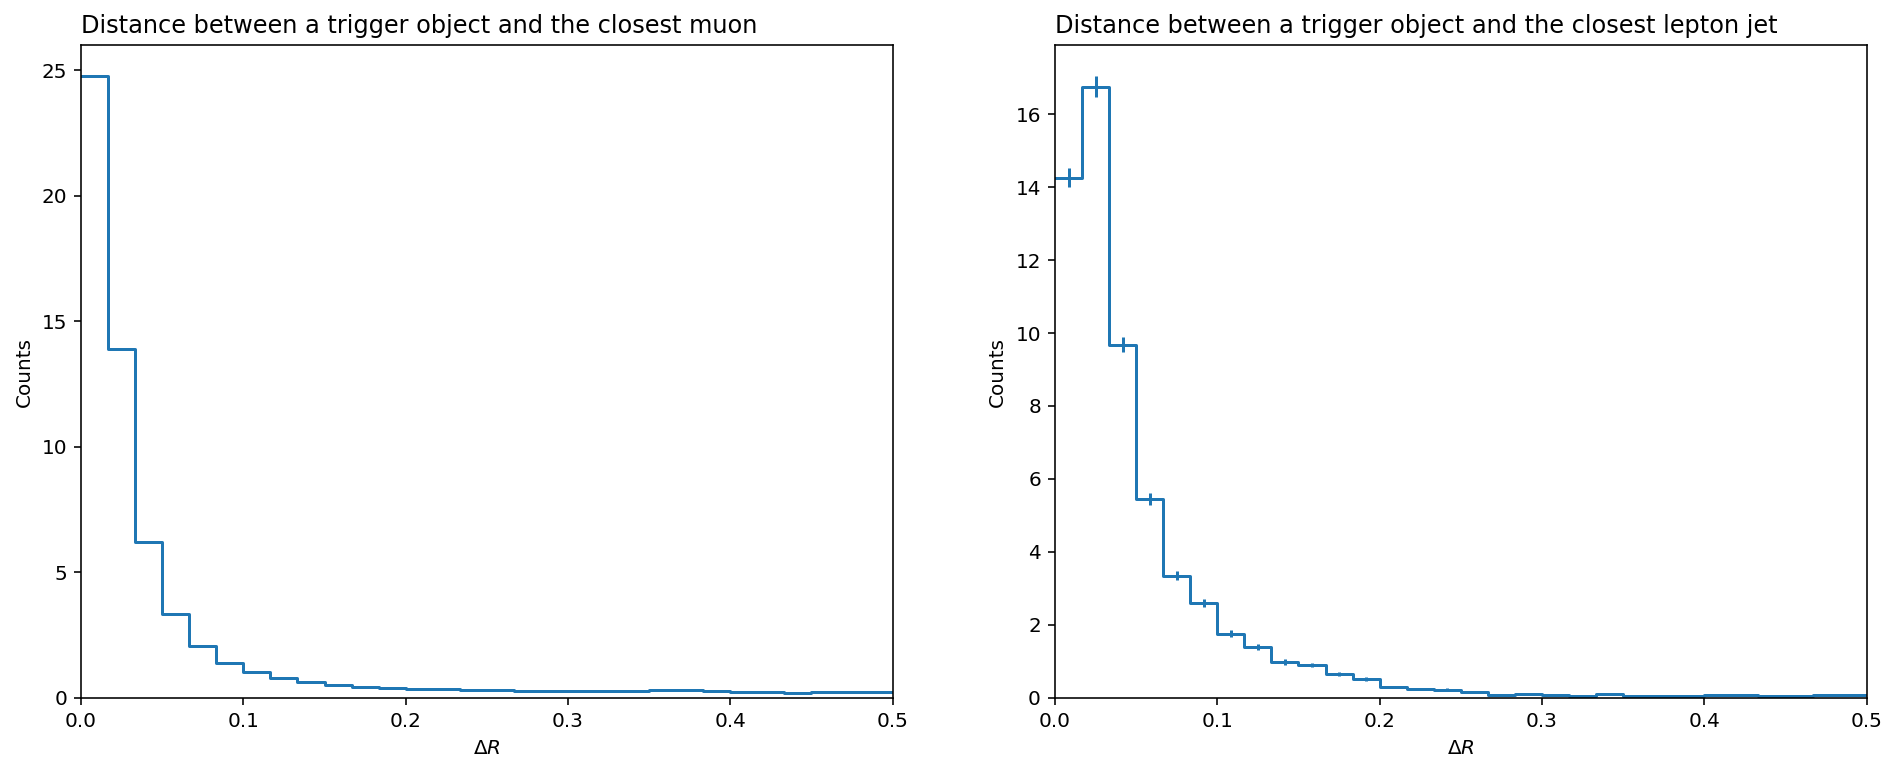

In [8]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

hist.plot1d(output['deltaR1'].sum('dataset'), ax=ax[0], density=True)
hist.plot1d(output['deltaR2'].sum('dataset'), ax=ax[1], density=True)

ax[0].set_title('Distance between a trigger object and the closest muon', x=0.0, ha="left")
ax[1].set_title('Distance between a trigger object and the closest lepton jet', x=0.0, ha="left");

## Per-object efficiency computation (efficiency vs pt)

##### Per-object efficiency is the probability for a LJ to contain at least 1 TO

##### The computation is performed with tag and probe method:

##### Tag and probe method description: 
- I select all possible pairs of Mu-type LJs (same event)
- I consider all the pairs with at least a LJ (tag) containing at least a TO 
- The other LJ (probe) can either contain a TO (good probe) or not (bad probe).  
- Tag must be matched by a reference trigger object too
- A TO is contained in a LJ if: ΔR < 0.4

##### Notes:
- Each LJ can be both tag and probe →  roles will be inverted 
- I use only tag and probe that have DeltaR > 0.4x2
- The efficiency is computed as a function of probe jet pt (later it'll be computed for probe jet eta)

##### The probabilty for a LJ to contain at least 1 TO can be divided into 2 parts:

- probability for a LJ to contain exaclty 1 TO
- probability for a LJ to contain at least 2 TOs

##### I try with 2 different reference trigggers:
- HLT_Mu50
- HLT_MuIso24

##### Here I compare per-object efficiency when using HLT_Mu50 or HLT_MuIso24 or no recerence trigger  


In [6]:
class ProcessorEfficienyVsPt(processor.ProcessorABC):
    def __init__(self):
        
        pt_binning = np.concatenate([np.arange(0  , 100, 20),
                             np.arange(100, 200, 40),
                             np.arange(200, 400, 70),
                             np.arange(400, 800, 100)])

        dataset_axis = hist.Cat('dataset', '')
        multiplicity_axis = hist.Bin("multiplicity", "#muons/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "probe jet pt [GeV]", pt_binning)
        deltaR_axis = hist.Bin("deltaR", "delta_R", 30, 0 , 5)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'numerator_Mu50_N>=1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_Mu50_N>=1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'numerator_Iso24_N>=1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_Iso24_N>=1': hist.Hist("Efficiency", dataset_axis, pt_axis),           
            'numerator_NoRef_N>=1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_NoRef_N>=1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            
            'numerator_Mu50_N==1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_Mu50_N==1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'numerator_Iso24_N==1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_Iso24_N==1': hist.Hist("Efficiency", dataset_axis, pt_axis),           
            'numerator_NoRef_N==1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_NoRef_N==1': hist.Hist("Efficiency", dataset_axis, pt_axis),
            
            
            'numerator_Mu50_N>=2': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_Mu50_N>=2': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'numerator_Iso24_N>=2': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_Iso24_N>=2': hist.Hist("Efficiency", dataset_axis, pt_axis),           
            'numerator_NoRef_N>=2': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator_NoRef_N>=2': hist.Hist("Efficiency", dataset_axis, pt_axis),
            
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            muonsPerJet=df["pfjet_muon_n"],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        ) 
       
        triggerObjs={} 
        for t in TriggerList:
            triggerObjs[t] = JaggedCandidateArray.candidatesfromcounts(
                                                        df['TO' + t],
                                                        px=df['TO' + t +'.fCoordinates.fX'],
                                                        py=df['TO' + t +'.fCoordinates.fY'],
                                                        pz=df['TO' + t +'.fCoordinates.fZ'],
                                                        energy=df['TO' + t +'.fCoordinates.fT'],
                                                        )  
        
        # reference triggers HLT_Mu50 and HLT_IsoMu24
        
        Rtrigger50Objs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_Mu50'],
            px=df['TOHLT_Mu50.fCoordinates.fX'],
            py=df['TOHLT_Mu50.fCoordinates.fY'],
            pz=df['TOHLT_Mu50.fCoordinates.fZ'],
            energy=df['TOHLT_Mu50.fCoordinates.fT'],
        )   
        RtriggerIso24Objs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_IsoMu24'],
            px=df['TOHLT_IsoMu24.fCoordinates.fX'],
            py=df['TOHLT_IsoMu24.fCoordinates.fY'],
            pz=df['TOHLT_IsoMu24.fCoordinates.fZ'],
            energy=df['TOHLT_IsoMu24.fCoordinates.fT'],
        )  
      
        twoljs = leptonjets.counts >=2
        
        diljs = leptonjets[ twoljs ]
     
        triggerObjs_ = {}
        for t in TriggerList:
            triggerObjs_[t] = triggerObjs[t][twoljs]
        
        Rtrigger50Objs_ = Rtrigger50Objs[twoljs]
        RtriggerIso24Objs_ = RtriggerIso24Objs[twoljs]
          
        if diljs.size == 0:
        
            return output
        
        for t in TriggerList:             
            if triggerObjs_[t].size == 0:
            
                return output
          
        def numTOsPerLJ(triggerObjs, leptonJets, dR = 0.4):
            combs = leptonJets.p4.cross(triggerObjs.p4, nested=True)
            deltaRs = combs.i0.delta_r(combs.i1)
            deltaRMask = deltaRs < dR
            return deltaRMask.sum()
       
        def numTOsPerLJ_mask(triggerObjs_, leptonJets, dR = 0.4, bool_cond_string = 'N>=1'):
            
            Nmasks = {}
            for t in TriggerList:
                combs = leptonJets.p4.cross(triggerObjs_[t].p4, nested=True)
                deltaRs = combs.i0.delta_r(combs.i1)
                deltaRMask = deltaRs < dR
                N =  deltaRMask.sum() 
                Nmasks[t] = eval(bool_cond_string) 
            
            trgmaskOR_content = np.logical_or.reduce([Nmasks[t].content for t in TriggerList])
            trgmaskOR = JaggedArray.fromcounts(diljs.counts, trgmaskOR_content)
          
            return trgmaskOR
               
        NO_Rtrmask =  numTOsPerLJ(Rtrigger50Objs_, diljs, dR = 0.4) >=0
        Rtrg50mask =  numTOsPerLJ(Rtrigger50Objs_, diljs, dR = 0.4) >= 1
        RtrgIso24mask =  numTOsPerLJ(RtriggerIso24Objs_, diljs, dR = 0.4) >= 1
    
       
        # add cut: tag and probe not too much close to each other
        noClose_LJ = diljs.distincts().i0.p4.delta_r(diljs.distincts().i1.p4) > 0.8
       
        muonTypeLJ = diljs.muonsPerJet >=1
        
        
        trgmask_atLeastOne =  numTOsPerLJ_mask(triggerObjs_, diljs, dR = 0.4, bool_cond_string = 'N>=1')
        
        for bool_cond in ['N>=1','N==1','N>=2']:
       
        
            trgmask = numTOsPerLJ_mask(triggerObjs_, diljs, dR = 0.4, bool_cond_string = bool_cond)
            
           
        
    
            ###### NO reference trigger ######
   
            Rtrgmask = NO_Rtrmask
        
            # i0 = tag and i1 = probe 
            denominatorA = diljs.distincts().i1[trgmask_atLeastOne.distincts().i0 &
                                            Rtrgmask.distincts().i0 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorA = diljs.distincts().i1[trgmask.distincts().i1 &
                                              trgmask_atLeastOne.distincts().i0 & 
                                              Rtrgmask.distincts().i0 &
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]

            # i1 = tag and i0 = probe 
            denominatorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                            Rtrgmask.distincts().i1 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                              trgmask.distincts().i0 & 
                                              Rtrgmask.distincts().i1 & 
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]
        
        
            # appendinding the two parts
            denominator = np.append(denominatorA.pt.flatten().tolist(), denominatorB.pt.flatten().tolist())
            numerator = np.append(numeratorA.pt.flatten().tolist(), numeratorB.pt.flatten().tolist())      
            # filling
            output['denominator_NoRef_'+ bool_cond].fill(dataset=dataset, pt=denominator)         
            output['numerator_NoRef_' + bool_cond].fill(dataset=dataset, pt=numerator)    
        
     
    
    
    
            ###### Mu50 reference trigger ######
   
            Rtrgmask = Rtrg50mask
        
            # i0 = tag and i1 = probe 
            denominatorA = diljs.distincts().i1[trgmask_atLeastOne.distincts().i0 &
                                            Rtrgmask.distincts().i0 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorA = diljs.distincts().i1[trgmask.distincts().i1 &
                                              trgmask_atLeastOne.distincts().i0 & 
                                              Rtrgmask.distincts().i0 &
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]

            # i1 = tag and i0 = probe 
            denominatorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                            Rtrgmask.distincts().i1 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                              trgmask.distincts().i0 & 
                                              Rtrgmask.distincts().i1 & 
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]
        
        
            # appendinding the two parts
            denominatorMu50 = np.append(denominatorA.pt.flatten().tolist(), denominatorB.pt.flatten().tolist())
            numeratorMu50 = np.append(numeratorA.pt.flatten().tolist(), numeratorB.pt.flatten().tolist())      
            # filling
            output['denominator_Mu50_'+ bool_cond].fill(dataset=dataset, pt=denominatorMu50)         
            output['numerator_Mu50_' + bool_cond].fill(dataset=dataset, pt=numeratorMu50)    
        
    
    
    
            ####### Iso24 reference trigger ######

            Rtrgmask = RtrgIso24mask
        
            # i0 = tag and i1 = probe 
            denominatorA = diljs.distincts().i1[trgmask_atLeastOne.distincts().i0 &
                                            Rtrgmask.distincts().i0 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorA = diljs.distincts().i1[trgmask.distincts().i1 &
                                              trgmask_atLeastOne.distincts().i0 & 
                                              Rtrgmask.distincts().i0 &
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]

            # i1 = tag and i0 = probe 
            denominatorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                            Rtrgmask.distincts().i1 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                              trgmask.distincts().i0 & 
                                              Rtrgmask.distincts().i1 & 
                                              noClose_LJ &
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]
                
        
            # appendinding the two parts
            denominatorIso24 = np.append(denominatorA.pt.flatten().tolist(), denominatorB.pt.flatten().tolist())
            numeratorIso24 = np.append(numeratorA.pt.flatten().tolist(), numeratorB.pt.flatten().tolist())        
            # filling
            output['denominator_Iso24_' + bool_cond].fill(dataset=dataset, pt=denominatorIso24)         
            output['numerator_Iso24_' + bool_cond].fill(dataset=dataset, pt=numeratorIso24)    
    

        return output
        
    
    def postprocess(self, accumulator):
        return accumulator

In [15]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=ProcessorEfficienyVsPt(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=5000,
                                  maxchunks=5
                                 )

## Comparison between with and without reference trigger (vs Pt)

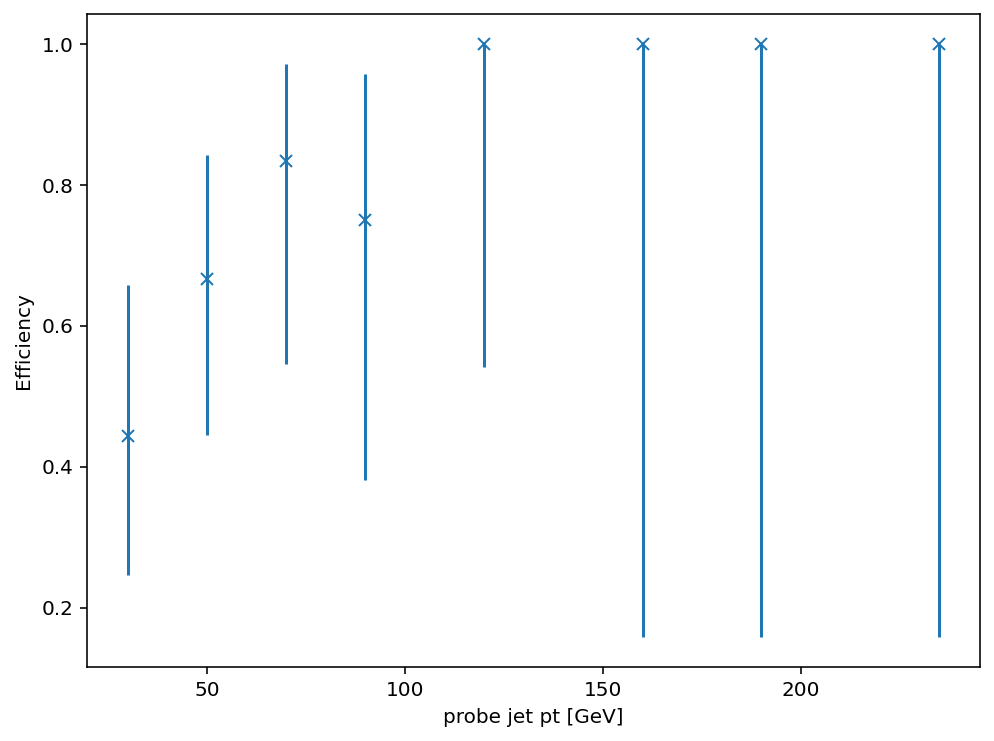

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

numerator_Mu50_N1_ = output['numerator_Mu50_N>=1'].integrate('dataset')
denominator_Mu50_N1_ = output['denominator_Mu50_N>=1'].integrate('dataset')

numerator_Iso24_N1_ = output['numerator_Iso24_N>=1'].integrate('dataset')
denominator_Iso24_N1_ = output['denominator_Iso24_N>=1'].integrate('dataset')

numerator_NoRef_N1_ = output['numerator_NoRef_N>=1'].integrate('dataset')
denominator_NoRef_N1_ = output['denominator_NoRef_N>=1'].integrate('dataset')


hist.plotratio(num=numerator_NoRef_N1_,
                            denom=denominator_NoRef_N1_,
                            clear = False,
                            error_opts={'marker': 'x'},
                            unc='clopper-pearson',
                            ax=ax)
#hist.plotratio(num=numerator_Mu50_N1_,
#    denom=denominator_Mu50_N1_,
#                            clear = False,
#                            error_opts={'marker': '+'},
#                            unc='clopper-pearson',
#                            ax=ax)

#fig, ax, _ = hist.plotratio(num=numerator_Iso24_N1_,
#fig, ax, _ = hist.plotratio(num=numerator_Iso24_N1_,
#                            denom=denominator_Iso24_N1_,
#                            clear = False,
#                            error_opts={'marker': '.'},
#                            unc='clopper-pearson',
#                            ax=ax)

#ax.set_title('[SingleMuon2018] per-object efficiency', x=0.0, ha="left")

#ax.text(45, 0.4, '\n Blue: HLT_MuIso24   \n Orange: HLT_Mu50  \n Green: No reference trigger');

## Probability for 1 or 2+ TOs (vs Pt)

NotImplementedError: Ratio for sparse axes (labeled axis with errorbars)

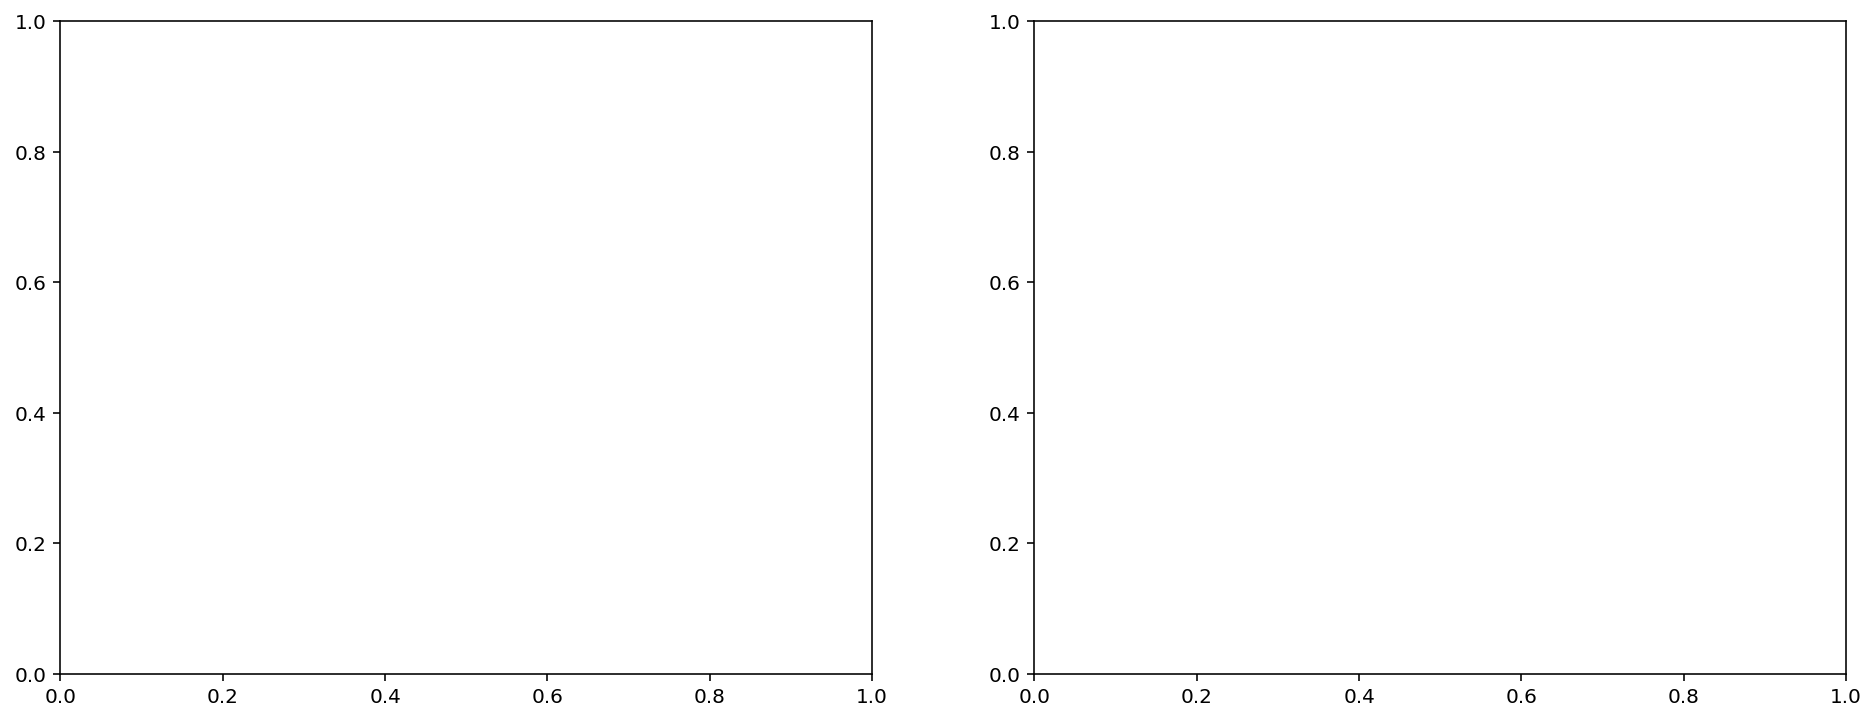

In [11]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

####### Mu50 reference trigger ######

numerator_Mu50_N1_ = output['numerator_Mu50_N>=1'].project('dataset')
denominator_Mu50_N1_ = output['denominator_Mu50_N>=1'].project('dataset')

numerator_Mu50_N1 = output['numerator_Mu50_N==1'].project('dataset')
denominator_Mu50_N1 = output['denominator_Mu50_N==1'].project('dataset')

numerator_Mu50_N2_ = output['numerator_Mu50_N>=2'].project('dataset')
denominator_Mu50_N2_ = output['denominator_Mu50_N>=2'].project('dataset')

fig, ax[0], _ = hist.plotratio(num=numerator_Mu50_N1_,
                            denom=denominator_Mu50_N1_,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[0])

fig, ax[0], _ = hist.plotratio(num=numerator_Mu50_N1,
                            denom=denominator_Mu50_N1,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[0])

fig, ax[0], _ = hist.plotratio(num=numerator_Mu50_N2_,
                            denom=denominator_Mu50_N2_,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[0])

####### Iso24 reference trigger ######

numerator_Iso24_N1_ = output['numerator_Iso24_N>=1'].project('dataset')
denominator_Iso24_N1_ = output['denominator_Iso24_N>=1'].project('dataset')

numerator_Iso24_N1 = output['numerator_Iso24_N==1'].project('dataset')
denominator_Iso24_N1 = output['denominator_Iso24_N==1'].project('dataset')

numerator_Iso24_N2_ = output['numerator_Iso24_N>=2'].project('dataset')
denominator_Iso24_N2_ = output['denominator_Iso24_N>=2'].project('dataset')

fig, ax[1], _ = hist.plotratio(num=numerator_Iso24_N1_,
                            denom=denominator_Iso24_N1_,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[1])

fig, ax[1], _ = hist.plotratio(num=numerator_Iso24_N1,
                            denom=denominator_Iso24_N1,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[1])

fig, ax[1], _ = hist.plotratio(num=numerator_Iso24_N2_,
                            denom=denominator_Iso24_N2_,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[1])

ax[0].set_title('[SingleMuon2018] per-object efficiency, reference trgger: HLT_Mu50 ', x=0.0, ha="left")
ax[1].set_title('[SingleMuon2018] per-object efficiency, reference trgger: HLT_MuIso24 ', x=0.0, ha="left");
    
ax[0].text(45, 0.4, '\n Blue: $\geq $ 1 TO matched \n Orange: 1 TO matched  \n Green: $\geq 2$ TO matched  ');
ax[1].text(45, 0.4, '\n Blue: $\geq $ 1 TO matched \n Orange: 1 TO matched  \n Green: $\geq 2$ TO matched  ');

In [30]:
class ProcessorEfficienyVsEta(processor.ProcessorABC):
    def __init__(self):

        dataset_axis = hist.Cat('dataset', '')
        multiplicity_axis = hist.Bin("multiplicity", "#muons/event", 10, 0, 10)
        eta_axis = hist.Bin("eta", "probe jet eta [rad]", 30, -3.5 , 3.5)
        deltaR_axis = hist.Bin("deltaR", "delta_R", 30, 0 , 5)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'numerator_Mu50_N>=1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_Mu50_N>=1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'numerator_Iso24_N>=1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_Iso24_N>=1': hist.Hist("Efficiency", dataset_axis, eta_axis),           
            'numerator_NoRef_N>=1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_NoRef_N>=1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            
            'numerator_Mu50_N==1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_Mu50_N==1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'numerator_Iso24_N==1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_Iso24_N==1': hist.Hist("Efficiency", dataset_axis, eta_axis),           
            'numerator_NoRef_N==1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_NoRef_N==1': hist.Hist("Efficiency", dataset_axis, eta_axis),
            
            
            'numerator_Mu50_N>=2': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_Mu50_N>=2': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'numerator_Iso24_N>=2': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_Iso24_N>=2': hist.Hist("Efficiency", dataset_axis, eta_axis),           
            'numerator_NoRef_N>=2': hist.Hist("Efficiency", dataset_axis, eta_axis),
            'denominator_NoRef_N>=2': hist.Hist("Efficiency", dataset_axis, eta_axis),
            
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            muonsPerJet=df["pfjet_muon_n"],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        ) 
       
        triggerObjs={} 
        for t in TriggerList:
            triggerObjs[t] = JaggedCandidateArray.candidatesfromcounts(
                                                        df['TO' + t],
                                                        px=df['TO' + t +'.fCoordinates.fX'],
                                                        py=df['TO' + t +'.fCoordinates.fY'],
                                                        pz=df['TO' + t +'.fCoordinates.fZ'],
                                                        energy=df['TO' + t +'.fCoordinates.fT'],
                                                        )  
        
        # reference triggers HLT_Mu50 and HLT_IsoMu24
        
        Rtrigger50Objs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_Mu50'],
            px=df['TOHLT_Mu50.fCoordinates.fX'],
            py=df['TOHLT_Mu50.fCoordinates.fY'],
            pz=df['TOHLT_Mu50.fCoordinates.fZ'],
            energy=df['TOHLT_Mu50.fCoordinates.fT'],
        )   
        RtriggerIso24Objs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_IsoMu24'],
            px=df['TOHLT_IsoMu24.fCoordinates.fX'],
            py=df['TOHLT_IsoMu24.fCoordinates.fY'],
            pz=df['TOHLT_IsoMu24.fCoordinates.fZ'],
            energy=df['TOHLT_IsoMu24.fCoordinates.fT'],
        )  
      
        twoljs = leptonjets.counts >=2
        
        diljs = leptonjets[ twoljs ]
     
        triggerObjs_ = {}
        for t in TriggerList:
            triggerObjs_[t] = triggerObjs[t][twoljs]
        
        Rtrigger50Objs_ = Rtrigger50Objs[twoljs]
        RtriggerIso24Objs_ = RtriggerIso24Objs[twoljs]
          
        if diljs.size == 0:
        
            return output
        
        #if triggerObjs_.size == 0:
        
        #    return output
        
        for t in TriggerList:             
            if triggerObjs_[t].size == 0:
            
                return output
          
        def numTOsPerLJ(triggerObjs, leptonJets, dR = 0.4):
            combs = leptonJets.p4.cross(triggerObjs.p4, nested=True)
            deltaRs = combs.i0.delta_r(combs.i1)
            deltaRMask = deltaRs < dR
            return deltaRMask.sum()
       
        def numTOsPerLJ_mask(triggerObjs_, leptonJets, dR = 0.4, bool_cond_string = 'N>=1'):
            
            Nmasks = {}
            for t in TriggerList:
                combs = leptonJets.p4.cross(triggerObjs_[t].p4, nested=True)
                deltaRs = combs.i0.delta_r(combs.i1)
                deltaRMask = deltaRs < dR
                N =  deltaRMask.sum() 
                Nmasks[t] = eval(bool_cond_string) 
            
            trgmaskOR_content = np.logical_or.reduce([Nmasks[t].content for t in TriggerList])
            trgmaskOR = JaggedArray.fromcounts(diljs.counts, trgmaskOR_content)
          
            return trgmaskOR
               
        NO_Rtrmask =  numTOsPerLJ(Rtrigger50Objs_, diljs, dR = 0.4) >=0
        Rtrg50mask =  numTOsPerLJ(Rtrigger50Objs_, diljs, dR = 0.4) >= 1
        RtrgIso24mask =  numTOsPerLJ(RtriggerIso24Objs_, diljs, dR = 0.4) >= 1
    
       
        # add cut: tag and probe not too much close to each other
        noClose_LJ = diljs.distincts().i0.p4.delta_r(diljs.distincts().i1.p4) > 0.8
       
        muonTypeLJ = diljs.muonsPerJet >=1
        
        
        trgmask_atLeastOne =  numTOsPerLJ_mask(triggerObjs_, diljs, dR = 0.4, bool_cond_string = 'N>=1')
        
        for bool_cond in ['N>=1','N==1','N>=2']:
       
        
            trgmask = numTOsPerLJ_mask(triggerObjs_, diljs, dR = 0.4, bool_cond_string = bool_cond)
            
           
        
    
            ###### NO reference trigger ######
   
            Rtrgmask = NO_Rtrmask
        
            # i0 = tag and i1 = probe 
            denominatorA = diljs.distincts().i1[trgmask_atLeastOne.distincts().i0 &
                                            Rtrgmask.distincts().i0 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorA = diljs.distincts().i1[trgmask.distincts().i1 &
                                              trgmask_atLeastOne.distincts().i0 & 
                                              Rtrgmask.distincts().i0 &
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]

            # i1 = tag and i0 = probe 
            denominatorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                            Rtrgmask.distincts().i1 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                              trgmask.distincts().i0 & 
                                              Rtrgmask.distincts().i1 & 
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]
        
        
            # appendinding the two parts
            denominator = np.append(denominatorA.eta.flatten().tolist(), denominatorB.eta.flatten().tolist())
            numerator = np.append(numeratorA.eta.flatten().tolist(), numeratorB.eta.flatten().tolist())      
            # filling
            output['denominator_NoRef_'+ bool_cond].fill(dataset=dataset, eta=denominator)         
            output['numerator_NoRef_' + bool_cond].fill(dataset=dataset, eta=numerator)    
        
     
            ###### Mu50 reference trigger ######
   
            Rtrgmask = Rtrg50mask
        
            # i0 = tag and i1 = probe 
            denominatorA = diljs.distincts().i1[trgmask_atLeastOne.distincts().i0 &
                                            Rtrgmask.distincts().i0 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorA = diljs.distincts().i1[trgmask.distincts().i1 &
                                              trgmask_atLeastOne.distincts().i0 & 
                                              Rtrgmask.distincts().i0 &
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]

            # i1 = tag and i0 = probe 
            denominatorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                            Rtrgmask.distincts().i1 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                              trgmask.distincts().i0 & 
                                              Rtrgmask.distincts().i1 & 
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]
        
        
            # appendinding the two parts
            denominatorMu50 = np.append(denominatorA.eta.flatten().tolist(), denominatorB.eta.flatten().tolist())
            numeratorMu50 = np.append(numeratorA.eta.flatten().tolist(), numeratorB.eta.flatten().tolist())      
            # filling
            output['denominator_Mu50_'+ bool_cond].fill(dataset=dataset, eta=denominatorMu50)         
            output['numerator_Mu50_' + bool_cond].fill(dataset=dataset, eta=numeratorMu50)    
        
    
    
    
            ####### Iso24 reference trigger ######

            Rtrgmask = RtrgIso24mask
        

      
        
            # i0 = tag and i1 = probe
            denominatorA = diljs.distincts().i1[trgmask_atLeastOne.distincts().i0 &
                                            Rtrgmask.distincts().i0 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorA = diljs.distincts().i1[trgmask.distincts().i1 &
                                              trgmask_atLeastOne.distincts().i0 & 
                                              Rtrgmask.distincts().i0 &
                                              noClose_LJ & 
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]

            # i1 = tag and i0 = probe 
            denominatorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                            Rtrgmask.distincts().i1 &
                                            noClose_LJ & 
                                            muonTypeLJ.distincts().i0 &
                                            muonTypeLJ.distincts().i1]
            numeratorB = diljs.distincts().i0[trgmask_atLeastOne.distincts().i1 &
                                              trgmask.distincts().i0 & 
                                              Rtrgmask.distincts().i1 & 
                                              noClose_LJ &
                                              muonTypeLJ.distincts().i0 &
                                              muonTypeLJ.distincts().i1]
                
        
            # appendinding the two parts
            denominatorIso24 = np.append(denominatorA.eta.flatten().tolist(), denominatorB.eta.flatten().tolist())
            numeratorIso24 = np.append(numeratorA.eta.flatten().tolist(), numeratorB.eta.flatten().tolist())        
            # filling
            output['denominator_Iso24_' + bool_cond].fill(dataset=dataset, eta=denominatorIso24)         
            output['numerator_Iso24_' + bool_cond].fill(dataset=dataset, eta=numeratorIso24)    
    

        return output
        
    
    def postprocess(self, accumulator):
        return accumulator

In [31]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=ProcessorEfficienyVsEta(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  #maxchunks=100
                                 )

Processing: 100%|██████████| 1672/1672 [16:57<00:00,  1.64items/s]


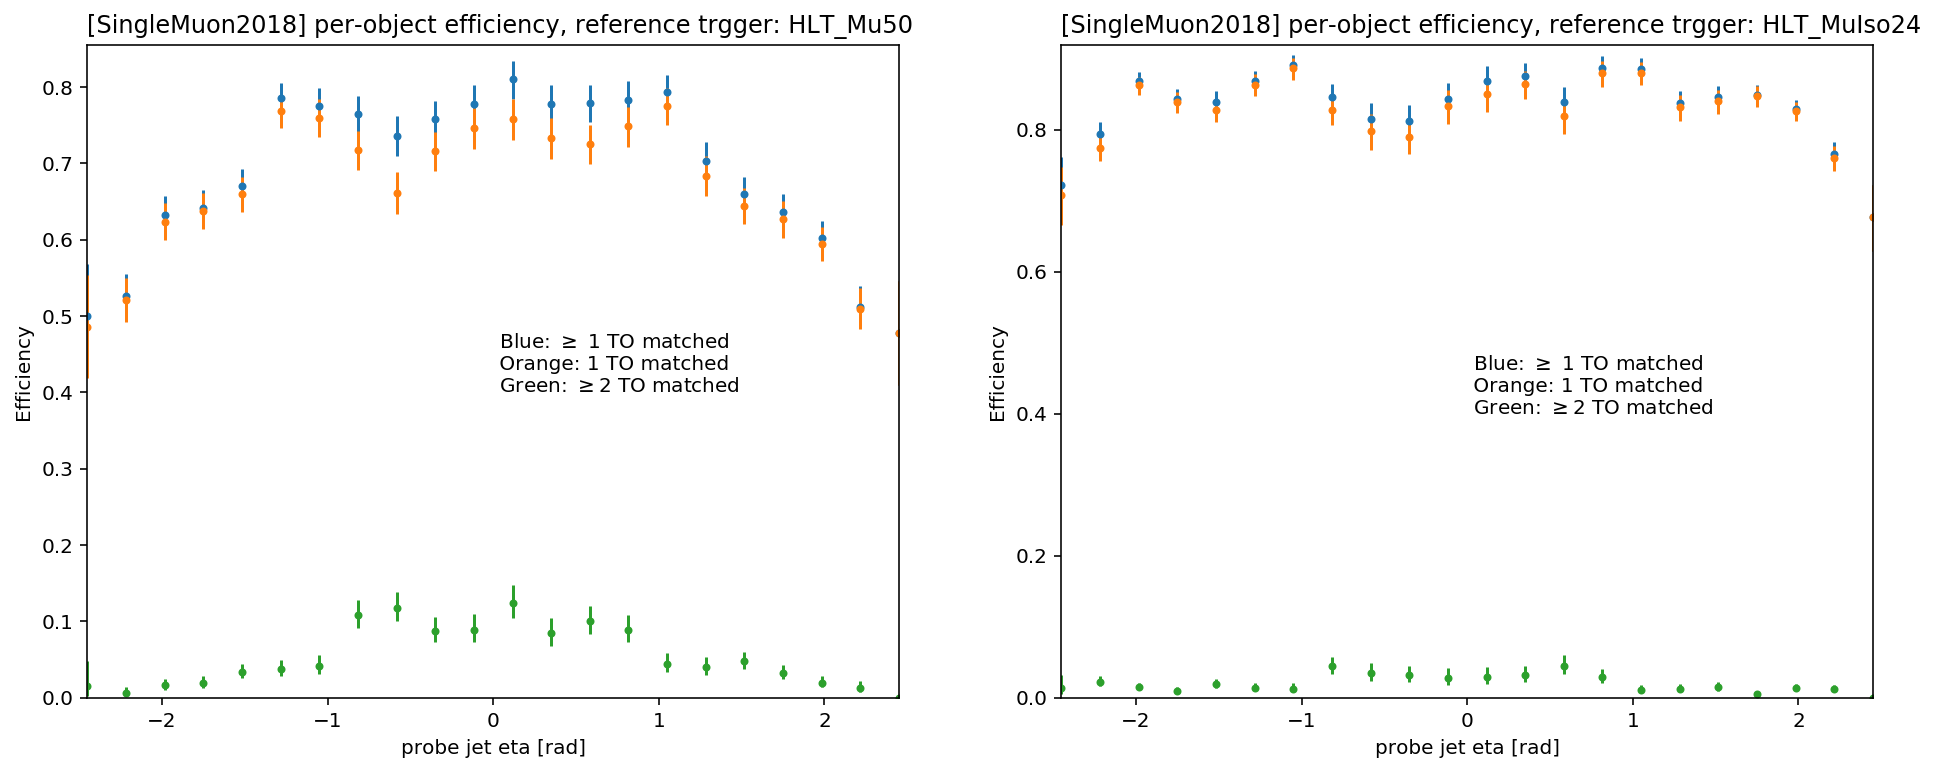

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

####### Mu50 reference trigger ######


numerator_Mu50_N1_ = output['numerator_Mu50_N>=1'].project('dataset')
denominator_Mu50_N1_ = output['denominator_Mu50_N>=1'].project('dataset')


numerator_Mu50_N1 = output['numerator_Mu50_N==1'].project('dataset')
denominator_Mu50_N1 = output['denominator_Mu50_N==1'].project('dataset')


numerator_Mu50_N2_ = output['numerator_Mu50_N>=2'].project('dataset')
denominator_Mu50_N2_ = output['denominator_Mu50_N>=2'].project('dataset')


fig, ax[0], _ = hist.plotratio(num=numerator_Mu50_N1_,
                            denom=denominator_Mu50_N1_,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[0])


fig, ax[0], _ = hist.plotratio(num=numerator_Mu50_N1,
                            denom=denominator_Mu50_N1,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[0])


fig, ax[0], _ = hist.plotratio(num=numerator_Mu50_N2_,
                            denom=denominator_Mu50_N2_,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[0])




####### Iso24 reference trigger ######


numerator_Iso24_N1_ = output['numerator_Iso24_N>=1'].project('dataset')
denominator_Iso24_N1_ = output['denominator_Iso24_N>=1'].project('dataset')


numerator_Iso24_N1 = output['numerator_Iso24_N==1'].project('dataset')
denominator_Iso24_N1 = output['denominator_Iso24_N==1'].project('dataset')


numerator_Iso24_N2_ = output['numerator_Iso24_N>=2'].project('dataset')
denominator_Iso24_N2_ = output['denominator_Iso24_N>=2'].project('dataset')



fig, ax[1], _ = hist.plotratio(num=numerator_Iso24_N1_,
                            denom=denominator_Iso24_N1_,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[1])


fig, ax[1], _ = hist.plotratio(num=numerator_Iso24_N1,
                            denom=denominator_Iso24_N1,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[1])


fig, ax[1], _ = hist.plotratio(num=numerator_Iso24_N2_,
                            denom=denominator_Iso24_N2_,
                            clear = False,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax[1])



ax[0].set_title('[SingleMuon2018] per-object efficiency, reference trgger: HLT_Mu50 ', x=0.0, ha="left")
ax[1].set_title('[SingleMuon2018] per-object efficiency, reference trgger: HLT_MuIso24 ', x=0.0, ha="left");
    
ax[0].text(0, 0.4, '\n Blue: $\geq $ 1 TO matched \n Orange: 1 TO matched  \n Green: $\geq 2$ TO matched  ');
ax[1].text(0, 0.4, '\n Blue: $\geq $ 1 TO matched \n Orange: 1 TO matched  \n Green: $\geq 2$ TO matched  ');


## Example of computing per-event efficiency (combining per-object efficeincy) 
##### Per-event efficiency is the probability for an event with 2 LJs to contain 2 or more TOs
##### Per-event efficiency can be computed in 2 ways:
- Analythical method: just using probability reasonings: eff =  P(1)P(1)  + P(2+)P(2+) + 2P(0)P(2+) + 2P(1)P(2+)
- Montecarlo method: simulating how many TO are contained in a LJ and summing the number of TOs in 2 LJs
##### The Montecarlo method is a convinient way for computing per-event efficiency for events with more than 2 LJs. 
##### Here it is an example of the Montecarlo method for events with N LJs. But this is just a prototype (this part of code does not use variables from the above code)
##### This method should be improved to used binned histogram values, instead of plateau values

In [33]:
import random
import numpy as np

# defining per-object efficeincy: 
#
# obj_eff[0] -> probability that 1 LJ contains 0 TO (inefficiency = 1 - efficiency)      
# obj_eff[1] -> probability that 1 LJ contains 1 TO        
# obj_eff[2] -> probability that 1 LJ contains 2 TO (or more)
# the list can be expanded to any number of TOs

obj_eff = [0.13, 0.80, 0.13]
# NOTES:  - one can use the efficiency distribution instead of using a flat distribution
#                 - the overall efficiency is the sum of all elements excluding the first one (ie, inefficiency)
#                 - the sum of all elements (including the inefficiency) must be equal to 1

  
def TOs_in_oneLJ():
    rnd = random.random()
    if 0 < rnd < obj_eff[0]:
        return 0
    if obj_eff[0] < rnd < obj_eff[0] + obj_eff[1]:
        return 1
    if obj_eff[0] + obj_eff[1] < rnd < obj_eff[0] + obj_eff[1] + obj_eff[2]:
        return 2
    
def TOs_in_N_LJs(N=2):
    TOs_in_oneLJ_array = np.array([TOs_in_oneLJ() for i in range(N)])
    return np.sum(TOs_in_oneLJ_array) 
    

# computing per-event efficeincy (requiring at least 2 TOs in the event with N LJs)
TOs_in_N_LJs_array = np.array([TOs_in_N_LJs(N=2) for i in range( int(100)  )])
per_event_eff = np.size(TOs_in_N_LJs_array[TOs_in_N_LJs_array >= 2])/np.size(TOs_in_N_LJs_array)  


print(per_event_eff)

0.76
